count    768.000000
mean      79.799479
std      115.244002
min        0.000000
25%        0.000000
50%       30.500000
75%      127.250000
max      846.000000
Name: Insulin, dtype: float64
count    768.000000
mean      20.536458
std       15.952218
min        0.000000
25%        0.000000
50%       23.000000
75%       32.000000
max       99.000000
Name: SkinThickness, dtype: float64
¿Hay valores negativos en Insulin? 0
¿Hay valores negativos en SkinThickness? 0
count    394.000000
mean     155.548223
std      118.775855
min       14.000000
25%       76.250000
50%      125.000000
75%      190.000000
max      846.000000
Name: Insulin, dtype: float64
count    394.000000
mean      29.106599
std       10.504273
min        7.000000
25%       21.000000
50%       29.000000
75%       36.750000
max       63.000000
Name: SkinThickness, dtype: float64
¿Hay valores negativos después de imputación en Insulin? 0
¿Hay valores negativos después de imputación en SkinThickness? 0
Valores en Insulin  0
Va

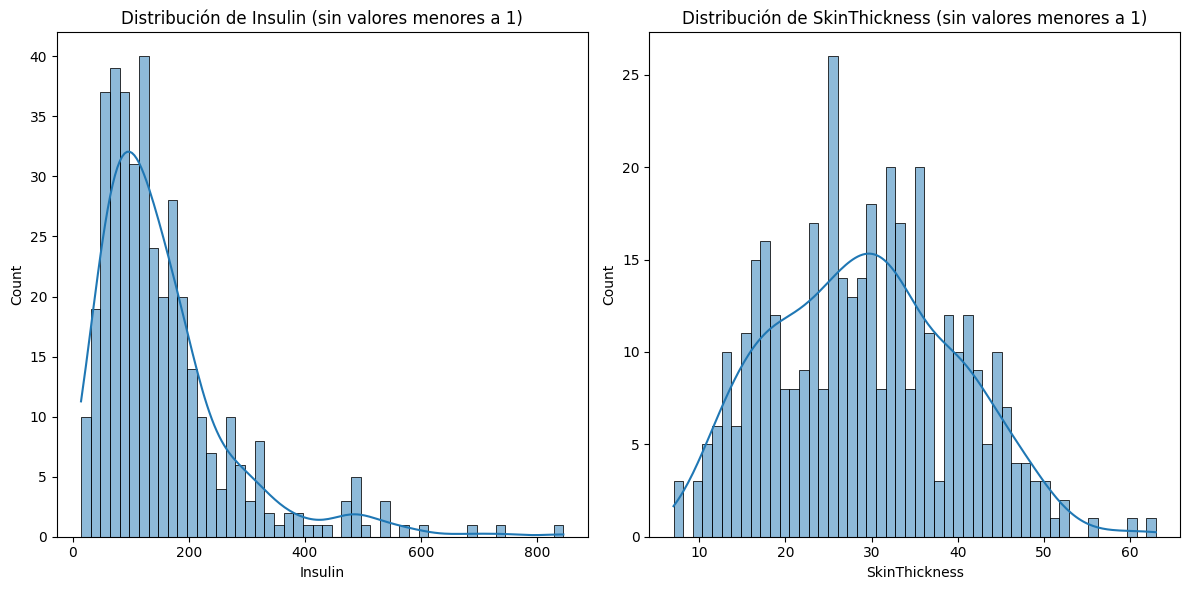

Resumen de Insulin (Box-Cox ajustada):
count    394.000000
mean       5.314514
std        0.834380
min        2.856913
25%        4.739106
50%        5.324782
75%        5.831667
max        7.715794
Name: Insulin_boxcox, dtype: float64

Resumen de SkinThickness (Box-Cox ajustada):
count    394.000000
mean      12.486713
std        3.297390
min        4.437313
25%       10.048439
50%       12.658267
75%       14.964204
max       21.783766
Name: SkinThickness_boxcox, dtype: float64

Lambda para Insulin: 0.03917484235442488
Lambda para SkinThickness: 0.655627469037298


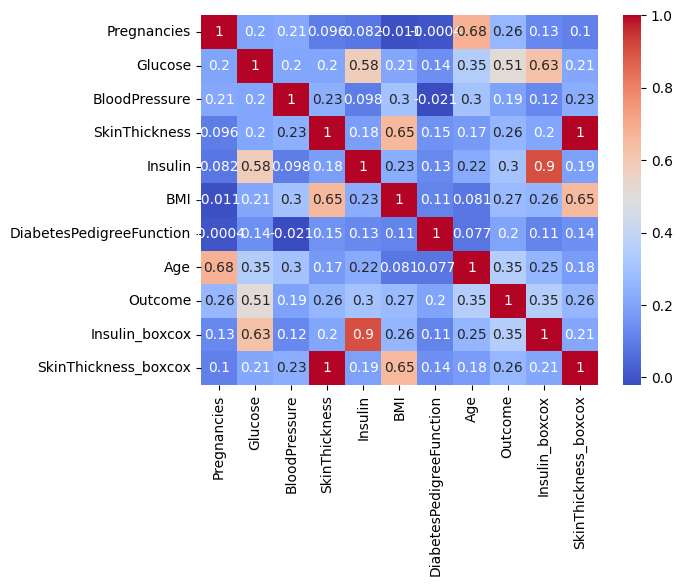

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros para Random Forest: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores parámetros para XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Matriz de Confusión Random Forest:
[[75  7]
 [16 21]]
Matriz de Confusión XGBoost:
[[73  9]
 [17 20]]
Random Forest ROC-AUC: 0.8450889914304549
XGBoost ROC-AUC: 0.8295978905735004
Random Forest F2-Score: 0.5965909090909091
XGBoost F2-Score: 0.5649717514124294
Random Forest Cross-Validation Accuracy: 0.7740019474196689
XGBoost Cross-Validation Accuracy: 0.7614086335605322


<ipython-input-2-703af90f09f8>:186: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')


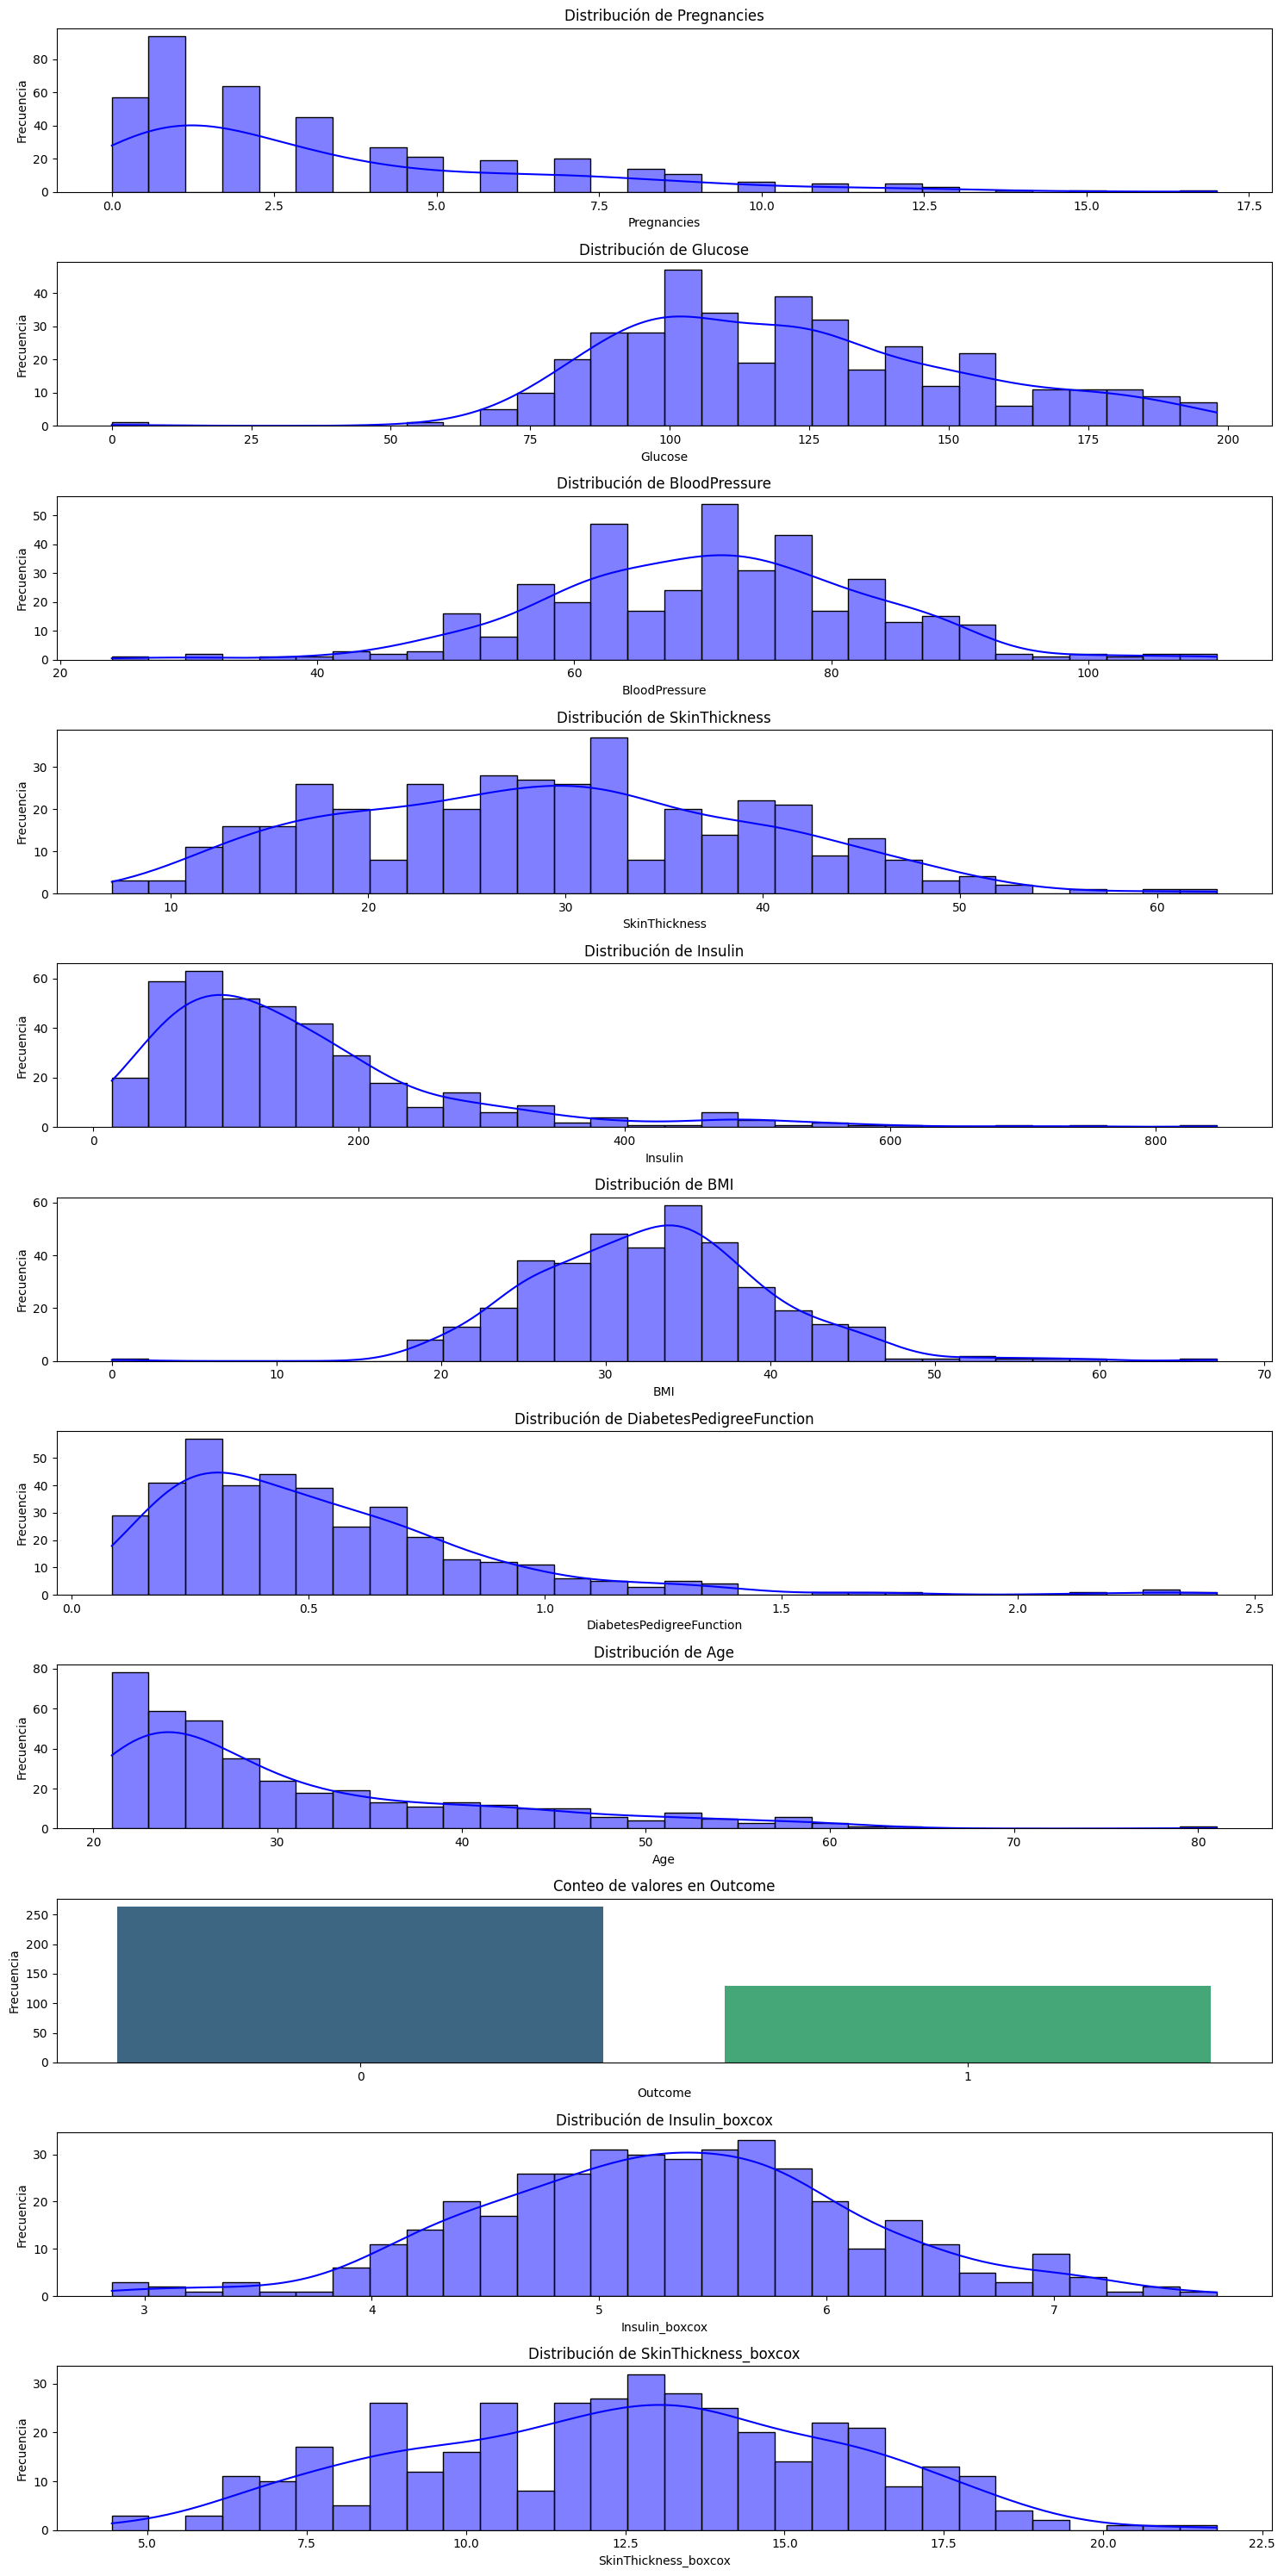

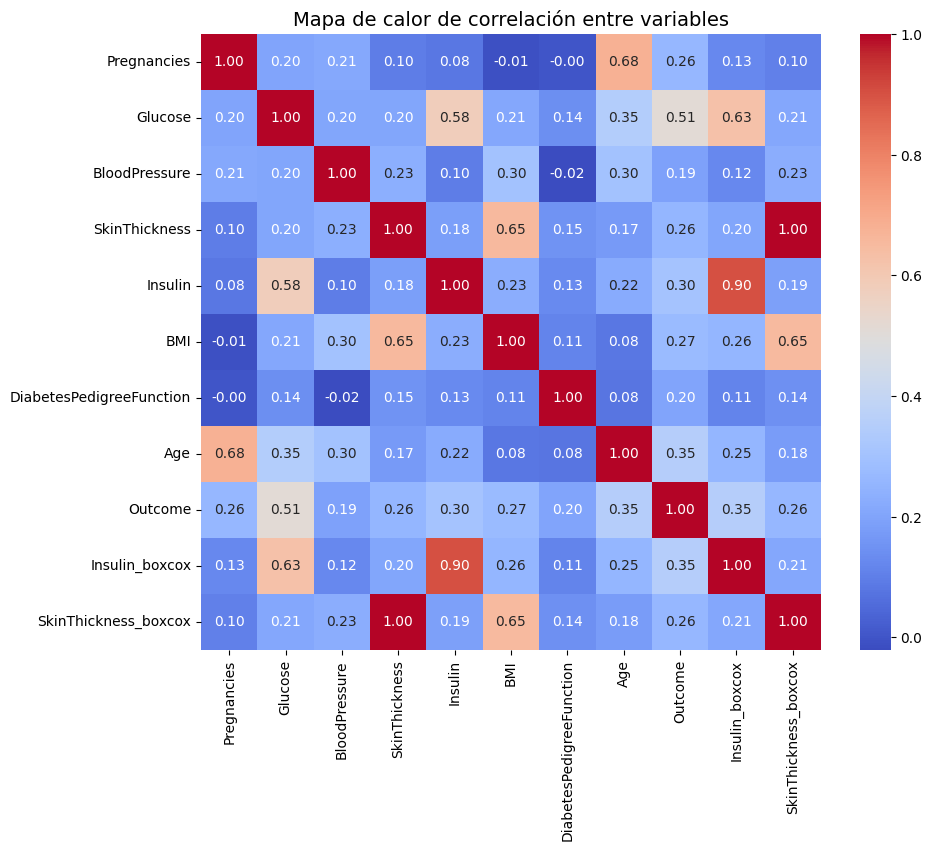

In [2]:
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_auc_score, fbeta_score
from sklearn.model_selection import cross_val_score

uploaded_file_path = '/content/diabetes.csv'  # Cambia la ruta si es necesario

df = pd.read_csv(uploaded_file_path)

# Eliminar duplicados
df = df.drop_duplicates()  # Eliminar duplicados

# Verificar los tipos de datos y convertir si es necesario
df.dtypes  # Verificar tipos de datos
df['Age'] = df['Age'].astype(int)  # Asegúrate de que 'Age' sea un tipo entero

# Unificar categorías en una columna (si es necesario)
df['DiabetesPedigreeFunction'] = df['DiabetesPedigreeFunction'].replace({'0.0': 'No', '1.0': 'Yes'})

# Estadísticas descriptivas antes de transformación
print(df['Insulin'].describe())
print(df['SkinThickness'].describe())

# Verificar si hay valores negativos o ceros en 'Insulin' y 'SkinThickness'
print("¿Hay valores negativos en Insulin?", (df['Insulin'] < 0).sum())
print("¿Hay valores negativos en SkinThickness?", (df['SkinThickness'] < 0).sum())

# Eliminar las filas donde 'Insulin' o 'SkinThickness' son cero
df = df[(df['Insulin'] > 0) & (df['SkinThickness'] > 0)]

# Imputación de valores nulos con la mediana
df['Insulin'] = df['Insulin'].fillna(df['Insulin'].median())
df['SkinThickness'] = df['SkinThickness'].fillna(df['SkinThickness'].median())

# Estadísticas descriptivas después de imputación
print(df['Insulin'].describe())
print(df['SkinThickness'].describe())

# Verificar de nuevo después de imputación
print("¿Hay valores negativos después de imputación en Insulin?", (df['Insulin'] < 0).sum())
print("¿Hay valores negativos después de imputación en SkinThickness?", (df['SkinThickness'] < 0).sum())

# Aplicamos Box-Cox solo si los valores son estrictamente positivos
if (df['Insulin'] > 0).all():  # Verifica que todos los valores sean positivos
    df['Insulin_boxcox'], lambda_insulin = stats.boxcox(df['Insulin'] + 1)
else:
    df['Insulin_boxcox'] = df['Insulin']  # Dejarlo sin transformar si no se cumplen las condiciones

if (df['SkinThickness'] > 0).all():  # Verifica que todos los valores sean positivos
    df['SkinThickness_boxcox'], lambda_skinthickness = stats.boxcox(df['SkinThickness'] + 1)
else:
    df['SkinThickness_boxcox'] = df['SkinThickness']  # Dejarlo sin transformar si no se cumplen las condiciones

# Filtrar valores menores a un umbral
umbral_minimo = 1

# Aplicar el filtro en las columnas originales
df = df[(df['Insulin'] >= umbral_minimo) & (df['SkinThickness'] >= umbral_minimo)]

# Aplicar el filtro en las transformaciones también (por si acaso persisten valores)
df = df[(df['Insulin_boxcox'] >= umbral_minimo) & (df['SkinThickness_boxcox'] >= umbral_minimo)]

# Verificar que no queden valores menores al umbral
print("Valores en Insulin ", (df['Insulin'] < umbral_minimo).sum())
print("Valores en SkinThickness", (df['SkinThickness'] < umbral_minimo).sum())

# Visualizar las distribuciones después del filtrado
plt.figure(figsize=(12, 6))
for i, col in enumerate(['Insulin', 'SkinThickness'], 1):
    plt.subplot(1, 2, i)
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f'Distribución de {col} (sin valores menores a {umbral_minimo})')
plt.tight_layout()
plt.show()

# Resumen de los datos transformados
print("Resumen de Insulin (Box-Cox ajustada):")
print(df['Insulin_boxcox'].describe())
print("\nResumen de SkinThickness (Box-Cox ajustada):")
print(df['SkinThickness_boxcox'].describe())

# Mostrar lambda para cada transformación (esto muestra el valor usado por Box-Cox)
print("\nLambda para Insulin:", lambda_insulin)
print("Lambda para SkinThickness:", lambda_skinthickness)

# Evaluación de la correlación entre las variables
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

# Separar variables predictoras y objetivo
X = df[['Insulin', 'SkinThickness', 'Age', 'BMI', 'DiabetesPedigreeFunction']]
y = df['Outcome']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ajuste de hiperparámetros para Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                             param_grid=param_grid_rf,
                             cv=5, n_jobs=-1, verbose=2)

grid_search_rf.fit(X_train, y_train)
print("Mejores parámetros para Random Forest:", grid_search_rf.best_params_)

# Modelo Random Forest con los mejores parámetros
rf_model = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)
rf_model.fit(X_train, y_train)

# Ajuste de hiperparámetros para XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search_xgb = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42),
                               param_grid=param_grid_xgb,
                               cv=5, n_jobs=-1, verbose=2)

grid_search_xgb.fit(X_train, y_train)
print("Mejores parámetros para XGBoost:", grid_search_xgb.best_params_)

# Modelo XGBoost con los mejores parámetros
xgb_model = xgb.XGBClassifier(**grid_search_xgb.best_params_, random_state=42)
xgb_model.fit(X_train, y_train)

# Realizar predicciones con los modelos entrenados
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Matriz de Confusión
print("Matriz de Confusión Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))

print("Matriz de Confusión XGBoost:")
print(confusion_matrix(y_test, y_pred_xgb))

# ROC-AUC Score
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

print("Random Forest ROC-AUC:", roc_auc_rf)
print("XGBoost ROC-AUC:", roc_auc_xgb)

# F2-Score (usando fbeta_score con beta=2)
f2_rf = fbeta_score(y_test, y_pred_rf, beta=2)
f2_xgb = fbeta_score(y_test, y_pred_xgb, beta=2)

print("Random Forest F2-Score:", f2_rf)
print("XGBoost F2-Score:", f2_xgb)

# Cross-validation para Random Forest
cv_rf = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print("Random Forest Cross-Validation Accuracy:", cv_rf.mean())

# Cross-validation para XGBoost
cv_xgb = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
print("XGBoost Cross-Validation Accuracy:", cv_xgb.mean())

# Visualización de cada columna con títulos específicos
columns_to_plot = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
    'DiabetesPedigreeFunction', 'Age', 'Outcome', 'Insulin_boxcox', 'SkinThickness_boxcox'
]

plt.figure(figsize=(15, 30))  # Ajustar tamaño para mejor visualización de múltiples gráficos

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(len(columns_to_plot), 1, i)
    if df[col].dtype == 'object' or len(df[col].unique()) < 10:
        # Gráficos de conteo para variables categóricas o con pocos valores únicos
        sns.countplot(data=df, x=col, palette='viridis')
        plt.title(f'Conteo de valores en {col}', fontsize=12)
    else:
        # Gráficos de distribución para variables numéricas
        sns.histplot(df[col], kde=True, bins=30, color='blue')
        plt.title(f'Distribución de {col}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Frecuencia', fontsize=10)
    plt.tight_layout()

plt.show()

# Correlación para variables seleccionadas
plt.figure(figsize=(10, 8))
sns.heatmap(df[columns_to_plot].corr(), annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Mapa de calor de correlación entre variables', fontsize=14)
plt.show()
